Import libraries

In [160]:
# this allows our code to send HTTP requests to websites
import requests

# Extracting data from web pages.
from bs4 import BeautifulSoup

# for data manipulation and analysis
import pandas as pd

# Writing to a CSV File
import csv

# Pausing execution to avoid being blocked
import time

# for better display
from IPython.display import display

# for vizualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Numerical computing
import numpy as np

# Blocks FutureWarnings from being displayed in output
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


This code sends an HTTP request to Jumia's Phones & Tablets category page, mimicking a browser, and parses the HTML content while printing the response status code.

In [ ]:
url = "https://www.jumia.com.ng/phones-tablets/"

# Set headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

# Send the request and parse the HTML
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

print("Status Code:", response.status_code)

Define the Base URL and Headers

In [ ]:
# Base URL for Phones & Tablets category (pagination included)
base_url = "https://www.jumia.com.ng/computing/?page={page}#catalog-listing"

# Headers
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}


Initialize Product List and Loop Through Pages

In [ ]:
# List to store all product data
products = []

# Loop through pages 1 to 50
for page in range(1, 51):
    print(f"Scraping Page {page}...")  # Status update
    
    url = base_url.format(page=page)
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch Page {page}, skipping...")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    # Find all product cards
    items = soup.find_all("article", class_="prd _fb col c-prd")

    for item in items:
        title = item.find("h3", class_="name").text.strip() if item.find("h3", class_="name") else "No Title"
        price = item.find("div", class_="prc").text.strip() if item.find("div", class_="prc") else "No Price"
        old_price = item.find("div", class_="old").text.strip() if item.find("div", class_="old") else "No discount"
        discount = item.find("div", class_="bdg _dsct").text.strip() if item.find("div", class_="bdg _dsct") else "0%"
        rating = item.find("div", class_="stars _s").text.strip() if item.find("div", class_="stars _s") else "No rating"
        reviews = item.find("div", class_="rev").text.strip() if item.find("div", class_="rev") else "0 reviews"

        # Extract all badges 
        badges = item.find_all("span", class_="bdg")
        badge_texts = ", ".join([badge.text.strip() for badge in badges]) if badges else "No badges"

        # Append product data
        products.append([title, price, old_price, discount, rating, reviews, badge_texts])

    time.sleep(2)  # Pause to avoid being blocked


 Convert Data to DataFrame

In [ ]:
# Convert to DataFrame
comp_df = pd.DataFrame(products, columns=["Title", "Price", "Old Price", "Discount", "Rating", "Reviews", "Badges"])

Save Data to CSV

In [ ]:
# Save to CSV
df.to_csv("jumia_products_computing.csv", index=False)


Display Data

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Prevent text truncation
pd.set_option('display.width', 1000)  # Adjust table width

# Display first 5 rows
display(comp_df.head())

Read CSV file for phones and tablets into a Pandas DataFrame

In [ ]:
phones_df = pd.read_csv("jumia_products_phones&tablet.csv")
phones_df.head()

Created a new column, "Category", in the comp_df DataFrame and sets its value to "Computing" for all rows. This ensures that when merging DataFrames, each product retains its category for clear identification.

In [ ]:
comp_df["Category"] = "Computing"
comp_df.tail()

I made use of .loc[:, "Category"] to add a new column, "Category", to the phones_df DataFrame and assigns "Phones & Tablets" to all rows to ensure the assignment applies directly to phones_df, avoiding issues like chained assignment warnings.








In [ ]:
phones_df.loc[:, "Category"] = "Phones & Tablets"
phones_df.head()

In [141]:
def wrangle(comp_df, phones_df):
    # Merged DataFrame
    merged_df = pd.concat([comp_df, phones_df], ignore_index=True)

    # Clean Rating column
    merged_df["Rating"] = merged_df["Rating"].astype(str).str.replace(" out of 5", "", regex=False)
    merged_df["Rating"] = pd.to_numeric(merged_df["Rating"], errors="coerce").fillna(0)

    # Extract numeric values from Reviews column and create a new column
    merged_df["Review Count"] = merged_df["Reviews"].str.extract(r"\((\d+)\)").astype(float)

    # Keep only the rating values in Reviews column
    merged_df["Reviews"] = merged_df["Reviews"].str.extract(r"([\d.]+)").astype(float)

    # Drop Reviews column (data is same as Rating)
    merged_df.drop(columns=["Reviews"], inplace=True)

    # Drop discount column
    merged_df.drop(columns=["Discount"], inplace=True)

    # Convert Ratings to float
    merged_df["Rating"] = merged_df["Rating"].astype(float)

    # Remove currency symbol and commas 
    merged_df["Price"] = merged_df["Price"].str.replace(r"[₦,]", "", regex=True)
    
    # Handle 7488 - 7500 by extracting the first number
    merged_df["Price"] = merged_df["Price"].str.extract(r"(\d+)").astype(float)

    # Remove currency symbol and commas
    merged_df["Old Price"] = merged_df["Old Price"].str.replace(r"[₦,]", "", regex=True)
    
    # Convert to numeric, setting non-numeric values to NaN, then replace NaN with 0
    merged_df["Old Price"] = pd.to_numeric(merged_df["Old Price"], errors="coerce").fillna(0)

    # Calculate for discount
    merged_df["Discount %"] = ((merged_df["Old Price"] - merged_df["Price"]) / merged_df["Old Price"]) * 100

    # Convert -inf to 0
    merged_df["Discount %"] = merged_df["Discount %"].replace([-np.inf, np.inf], 0)

    # Fill NaN with 0
    merged_df["Review Count"] = merged_df["Review Count"].fillna(0)
    
    return merged_df 

Merged the comp_df and phones_df DataFrames by stacking them vertically using pd.concat()

In [140]:
merged_df.tail()

Title     Price  Old Price  Rating     Badges          Category  Review Count  Discount %
3995              Mini Mobile Phone LED Light- (Influencer Light) PINK   22800.0    25000.0     3.0  No badges  Phones & Tablets           2.0    8.800000
3996      Stainless Steel Smartwatch Strap Compatible Apple SILVER/BLK   14500.0    28000.0     0.0  No badges  Phones & Tablets           0.0   48.214286
3997  Tecno Camon 20/20 Pro 4G Solid Rugged Edge Transparent Back Case    2870.0     8000.0     1.0  No badges  Phones & Tablets           1.0   64.125000
3998          New Age NewAge Soul-Pods Ultra 1 Earbuds 6-Hour Playtime   14850.0    20000.0     0.0  No badges  Phones & Tablets           0.0   25.750000
3999                  Apple AirPods Pro (2nd Generation) USB‑C - White  499000.0   599000.0     5.0  No badges  Phones & Tablets           4.0   16.694491

In [80]:
# Columns to exclude
exclude_cols = ["Title", "Price", "Old Price"]

# Loop through each column and display unique values
for col in merged_df.columns:
    if col not in exclude_cols:
        print(f"Unique values in '{col}':")
        print(merged_df[col].unique(), "\n")


Unique values in 'Rating':
['4.1' '4.3' '4.4' '4.2' '3.5' '3.8' '4.5' '3.7' '3.9' '4.0' '3.0' '4.6'
 '3.6' '3.3' '3.4' '4.7' '0.0' '5.0' '4.9' '3.1' '4.8' '2.8' '1.0' '2.5'
 '2.0' '3.2' '2.3' '1.5' '2.7' '1.3' '1.7'] 

Unique values in 'Badges':
['Pay on Delivery' 'No badges' 'Buy Any 2 Get ₦850 Off' 'Non-returnable'] 

Unique values in 'Category':
['Computing' 'Phones & Tablets'] 

Unique values in 'Review Count':
[1.6540e+03 2.2860e+03 2.5170e+03 1.9430e+03 2.4880e+03 1.3330e+03
 4.0680e+03 4.5000e+01 1.6640e+03 1.4680e+03 1.9800e+02 1.0200e+03
 1.2340e+03 2.1000e+01 1.6000e+02 2.6000e+01 3.3400e+02 5.1700e+02
 2.4000e+01 6.8500e+02 1.5400e+02 2.9000e+02 2.0700e+02 9.1000e+01
 1.0960e+03 5.2000e+01 1.9000e+01 1.4200e+02 3.7000e+01 7.0000e+01
 4.0900e+02 4.2000e+01 2.5200e+02 1.5100e+02 2.6700e+02 5.0000e+00
 2.7000e+01 2.9700e+02 1.2900e+02 5.1000e+02 4.6800e+02 1.6100e+02
 8.3000e+01 3.1000e+01 8.9000e+01 3.1900e+02 5.9700e+02 2.0800e+02
 3.7500e+02 4.3000e+01 1.2200e+02 1.8000e+01 

In [98]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         4000 non-null   object 
 1   Price         4000 non-null   float64
 2   Old Price     4000 non-null   float64
 3   Rating        4000 non-null   float64
 4   Badges        4000 non-null   object 
 5   Category      4000 non-null   object 
 6   Review Count  3213 non-null   float64
dtypes: float64(4), object(3)
memory usage: 218.9+ KB


In [115]:
# Display the top 10 most reviewed products
print(top_reviewed[["Title", "Review Count", "Rating", "Price", "Discount %"]])

                                                                          Title  Review Count  Rating    Price  Discount %
2016                           Ace Elec 20000 MAh Utra Slim Portable Power Bank       40050.0     3.7   8021.0    0.000000
2015                          Ace Elec 20000 MAh Ultra Slim Portable Power Bank       32290.0     3.7   8370.0    0.000000
2017  Ace Elec 50000 MAh Power Banks With LED Light Portable Super Fast Charger       11149.0     3.6  25000.0    0.000000
2020                         itel 20000mAh Dual Output Fast Charging Power Bank       10952.0     3.9  15500.0   22.500000
2096                   EAGEAT F9 Bluetooth Headset Headphones Fingerprint Touch        7132.0     3.9   4900.0   50.995100
2025                               Oraimo Traveler 4 20000mAh 10.5W Power Banks        6866.0     3.9  17000.0   35.114504
2018                                        Philly 20000mAh Power Charging Bank        6504.0     3.6   7450.0   48.656099
2029     itel 1.

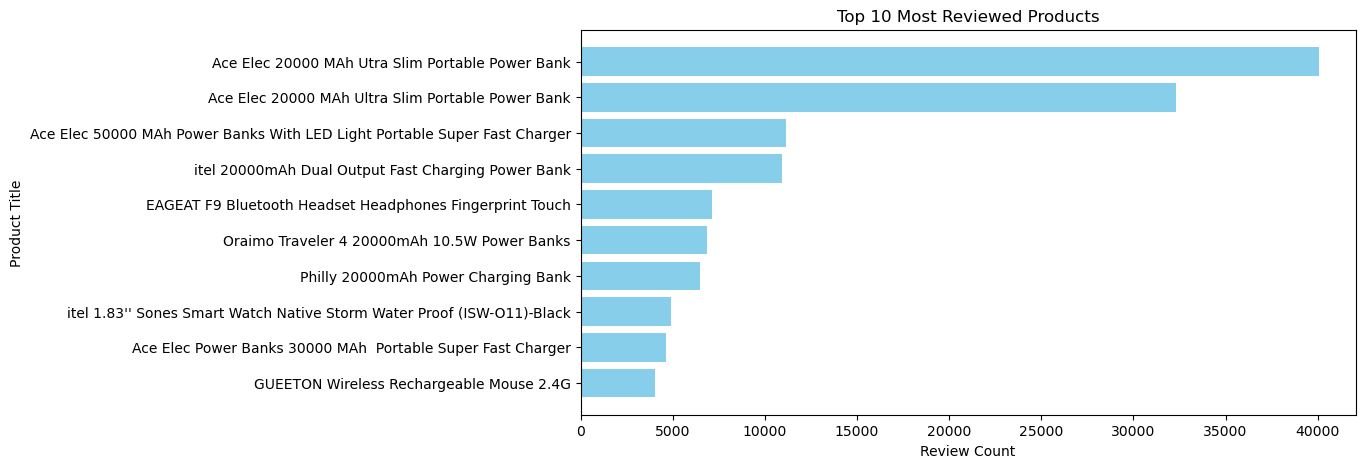

In [119]:
# Sort products by Review Count in descending order
top_reviewed = merged_df.sort_values(by="Review Count", ascending=False).head(10)

# Visualization
plt.figure(figsize=(10, 5))
plt.barh(top_reviewed["Title"], top_reviewed["Review Count"], color="skyblue")
plt.xlabel("Review Count")
plt.ylabel("Product Title")
plt.title("Top 10 Most Reviewed Products")
plt.gca().invert_yaxis() 
plt.show();

In [213]:
# Display the top 10 most reviewed products
display(top_discounted[["Title", "Review Count", "Rating", "Price", "Old Price", "Discount %"]])

Title  Review Count  Rating     Price   Old Price  Discount %
153                                        High Speed 4 Port USB 3.0 Multi HUB Splitter Expansion Hub 0024          18.0     3.3    3990.0   6847061.0   99.941727
1871                                                                         Sage 50 ( Formerly Peachtree)           NaN     0.0   20000.0  12000000.0   99.833333
2430                                                                         Earpiece, Headset, Hand Free,          17.0     3.2     458.0     20000.0   97.710000
1618                                             FYLO M1 BT+2.4G RGB Light Office Wireless Chargable Mouse           NaN     0.0    4999.0    189000.0   97.355026
3058                                                                        Super Earphone For Every Phone           3.0     4.7     594.0     19000.0   96.873684
2055                                                 VANIR Wireless In-ear Earbuds With Noise Cancellation         206.0     3.9   14460.0    300000.0   95.180000
953                                         Otg 2 In 1 O TG Type-C USB 3.0 Android Flash Drive Card Reader           NaN     0.0    2900.0     50000.0   94.200000
181   Hp ELITEBOOK X360 1030 G2 TOUCHSCREEN CORE I5 8GB RAM/ 1TB SSD BACKLIT KEYBOARD FP READER WIN 11 PRO           9.0     4.6  650000.0   9000000.0   92.777778
1799               Intuit QuickBooks Desktop Enterprise Solutions 2024 Platinum Edition - Original License           NaN     0.0   45000.0    600000.0   92.500000
401                                           Hp FLEXIBLE USB LIGHT FOR COMPUTERS,LAPTOP & POWER BANK BLUE           4.0     4.3    2500.0     33000.0   92.424242

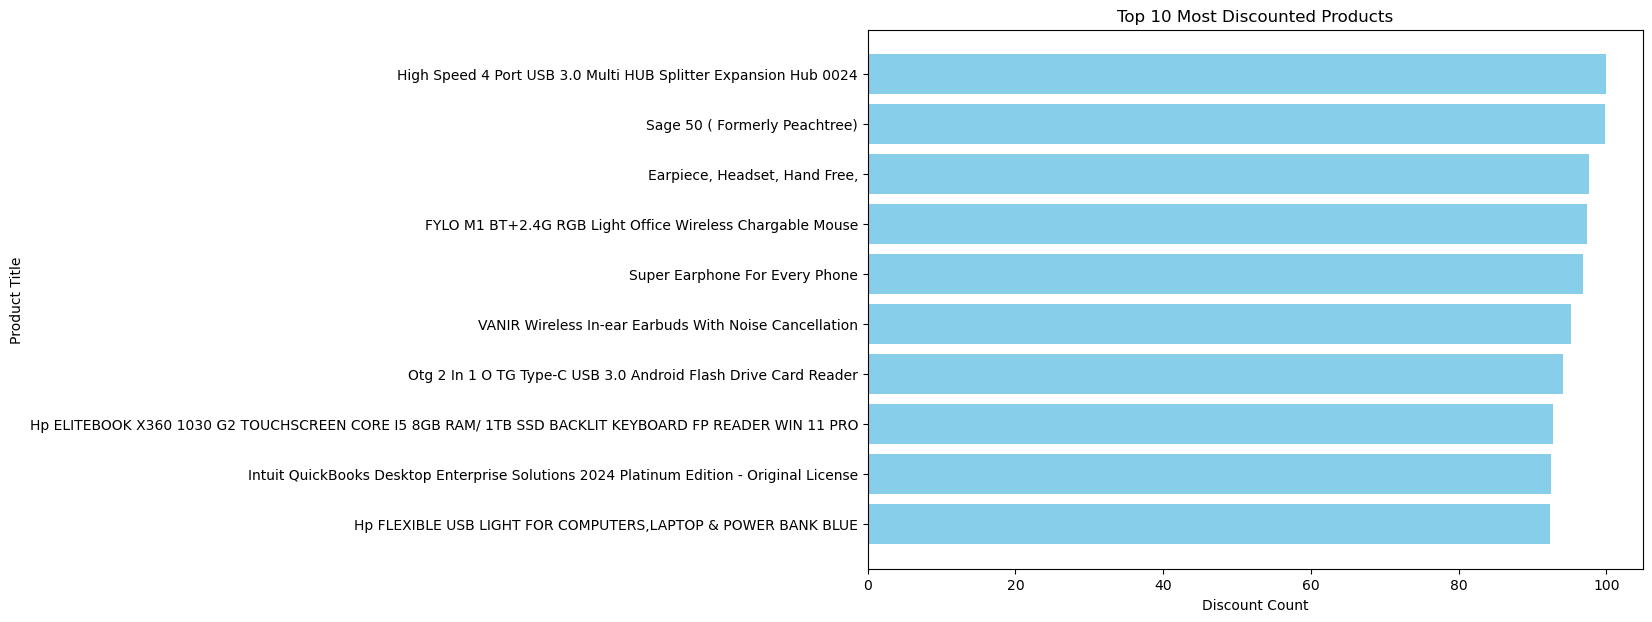

In [123]:
# Sort products by Discount in descending order
top_discounted = merged_df.sort_values(by="Discount %", ascending=False).head(10)

# Visualization
plt.figure(figsize=(10, 7))
plt.barh(top_discounted["Title"], top_discounted["Discount %"], color="skyblue")
plt.xlabel("Discount Count")
plt.ylabel("Product Title")
plt.title("Top 10 Most Discounted Products")
plt.gca().invert_yaxis()  
plt.show();

In [129]:
merged_df["Discount %"].describe().round(2)

count    4000.00
mean       24.79
std        23.14
min         0.00
25%         0.00
50%        22.47
75%        43.75
max        99.94
Name: Discount %, dtype: float64

In [130]:
merged_df["Price"].describe().round(2)

count       4000.00
mean      109209.93
std       373713.63
min          281.00
25%         6000.00
50%        15000.00
75%        45000.00
max      7500000.00
Name: Price, dtype: float64

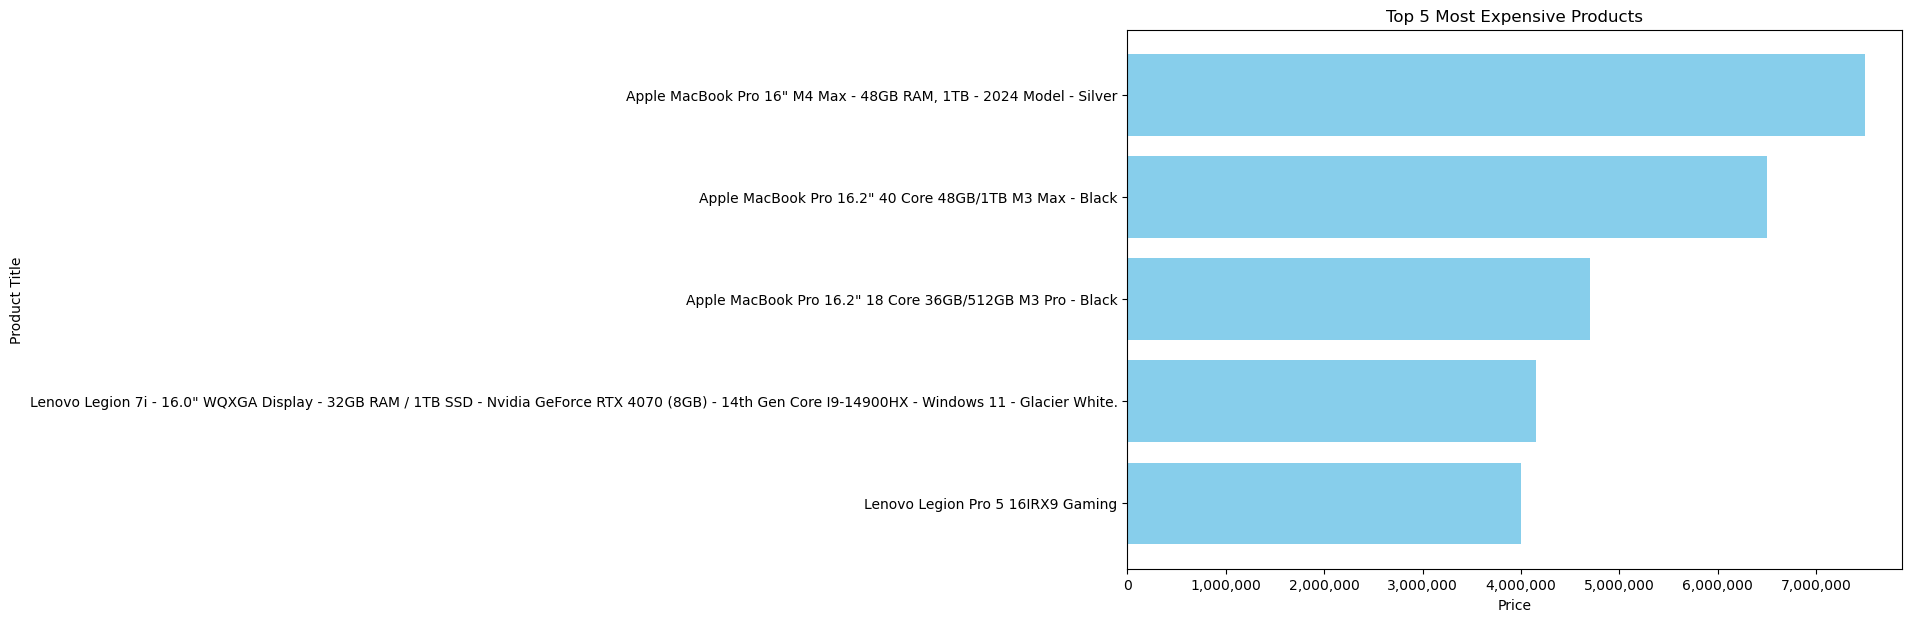

In [134]:
# Sort products by Price in descending order
most_expensive = merged_df.sort_values(by="Price", ascending=False).head(5)

# Visualization
plt.figure(figsize=(10, 7))
plt.barh(most_expensive["Title"], most_expensive["Price"], color="skyblue")
plt.xlabel("Price")
plt.ylabel("Product Title")
plt.title("Top 5 Most Expensive Products")
plt.gca().invert_yaxis()  
ax = plt.gca()  
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

Does price affect rating?

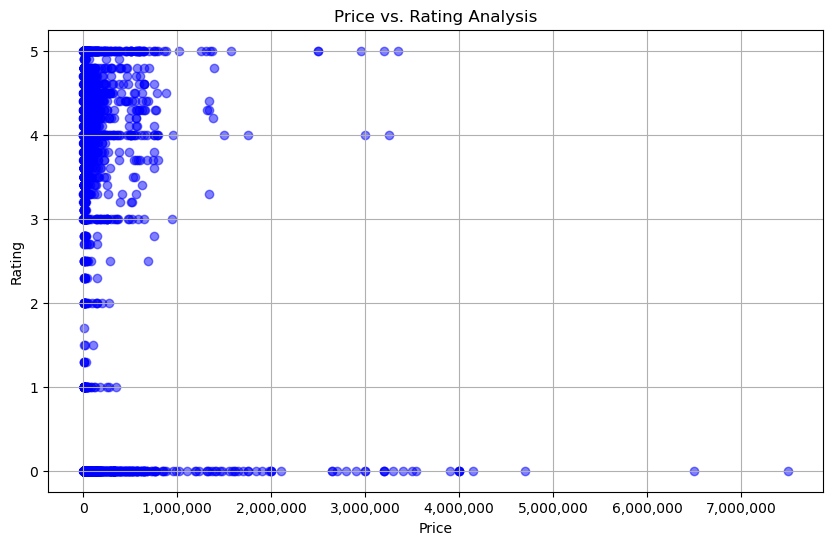

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["Price"], merged_df["Rating"], alpha=0.5, color="blue")
plt.xlabel("Price")
plt.ylabel("Rating")
plt.title("Price vs. Rating Analysis")
plt.grid(True)
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


In [144]:
correlation = merged_df["Price"].corr(merged_df["Rating"])
print(f"Correlation between Price and Rating: {correlation}")

Correlation between Price and Rating: -0.18060153022628642


In [146]:
correlation = merged_df["Discount %"].corr(merged_df["Review Count"])
print(f"Correlation between Discount and Reviews: {correlation}")


Correlation between Discount and Reviews: 0.007513837660729948


In [145]:
merged_df.head()

Title   Price  Old Price  Rating           Badges   Category  Review Count  Discount %
0              EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand  4274.0     4787.0     4.1  Pay on Delivery  Computing        1654.0   10.716524
1  LZDUATAN 10 Steps Laptop Stand Desktop Stand Can Be Adjusted In  3199.0     5324.0     4.3  Pay on Delivery  Computing        2286.0   39.913599
2   GUEETON LED 2.4G Rechargeable Wireless Mouse Bluetooth 2 Modes  4406.0     5537.0     4.4  Pay on Delivery  Computing        2517.0   20.426224
3                                   LZDUATAN 10 Steps Laptop Stand  2954.0     5000.0     4.2        No badges  Computing        1943.0   40.920000
4                  GUEETON 128GB OTG 3 In 1 Usb Flash Drive Type C  6695.0     9439.0     3.5  Pay on Delivery  Computing        2488.0   29.070876

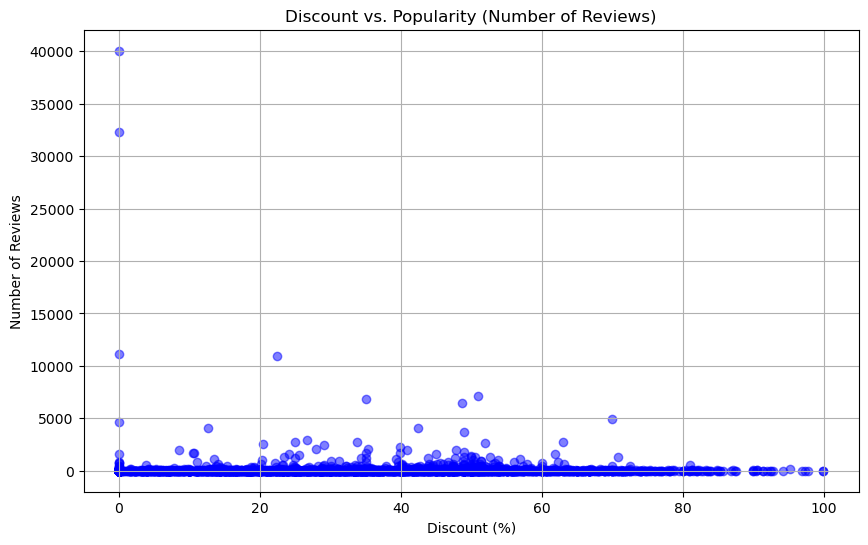

In [147]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["Discount %"], merged_df["Review Count"], alpha=0.5, color="blue")
plt.xlabel("Discount (%)")
plt.ylabel("Number of Reviews")
plt.title("Discount vs. Popularity (Number of Reviews)")
plt.grid(True)
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


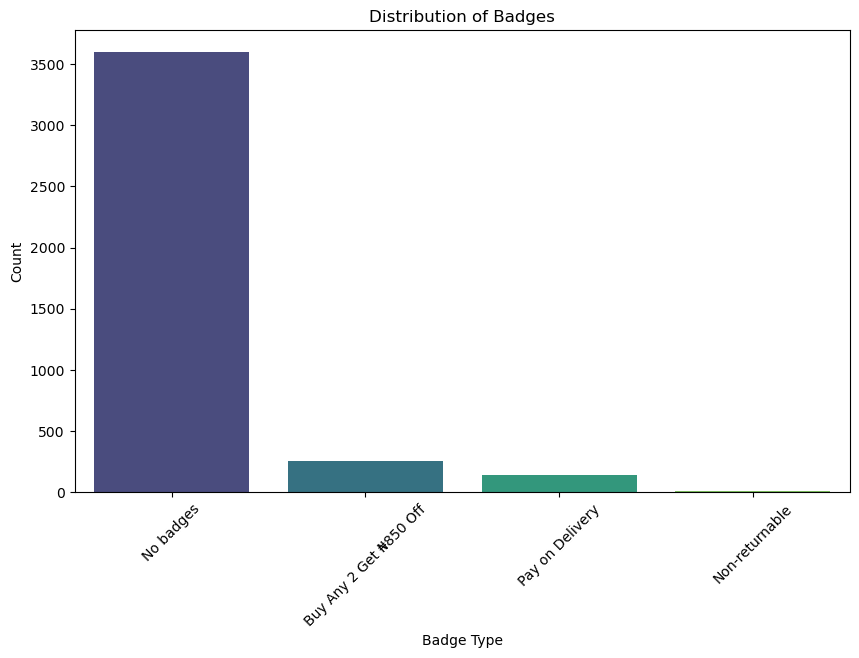

In [152]:
# Count of occurrences of each badge type
badge_counts = merged_df["Badges"].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=badge_counts.index, y=badge_counts.values, hue=badge_counts.index, palette="viridis", legend=False)

# Labels and title
plt.xlabel("Badge Type")
plt.ylabel("Count")
plt.title("Distribution of Badges")
plt.xticks(rotation=45)  

plt.show()

In [148]:
merged_df.head()

Title   Price  Old Price  Rating           Badges   Category  Review Count  Discount %
0              EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand  4274.0     4787.0     4.1  Pay on Delivery  Computing        1654.0   10.716524
1  LZDUATAN 10 Steps Laptop Stand Desktop Stand Can Be Adjusted In  3199.0     5324.0     4.3  Pay on Delivery  Computing        2286.0   39.913599
2   GUEETON LED 2.4G Rechargeable Wireless Mouse Bluetooth 2 Modes  4406.0     5537.0     4.4  Pay on Delivery  Computing        2517.0   20.426224
3                                   LZDUATAN 10 Steps Laptop Stand  2954.0     5000.0     4.2        No badges  Computing        1943.0   40.920000
4                  GUEETON 128GB OTG 3 In 1 Usb Flash Drive Type C  6695.0     9439.0     3.5  Pay on Delivery  Computing        2488.0   29.070876

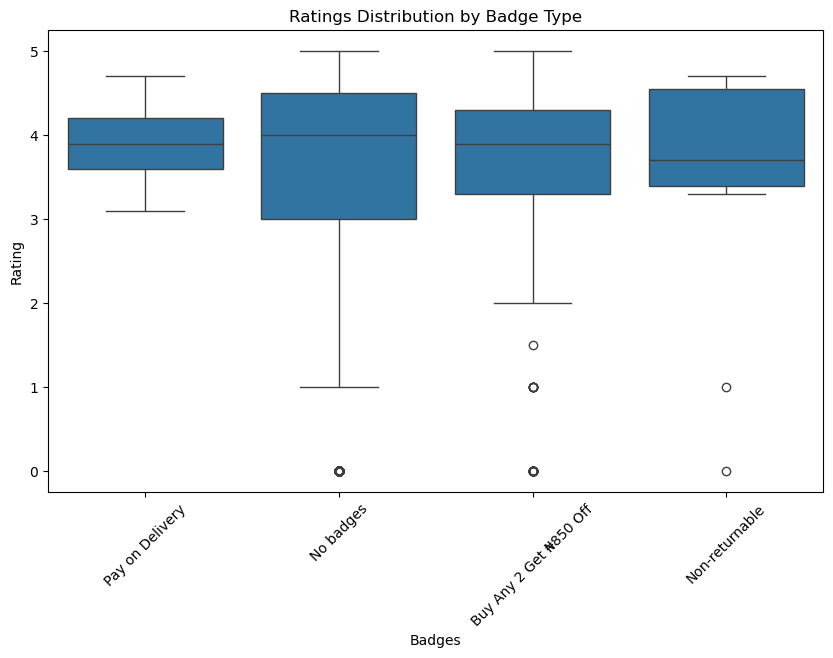

In [154]:
merged_df.groupby("Badges")["Rating"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Badges", y="Rating", data=merged_df)
plt.xticks(rotation=45)
plt.title("Ratings Distribution by Badge Type")
plt.show()


In [155]:
badge_dummies = pd.get_dummies(merged_df["Badges"])  
correlation = badge_dummies.corrwith(merged_df["Rating"])
print(correlation)


Buy Any 2 Get ₦850 Off    0.009790
No badges                -0.050057
Non-returnable            0.003921
Pay on Delivery           0.067924
dtype: float64


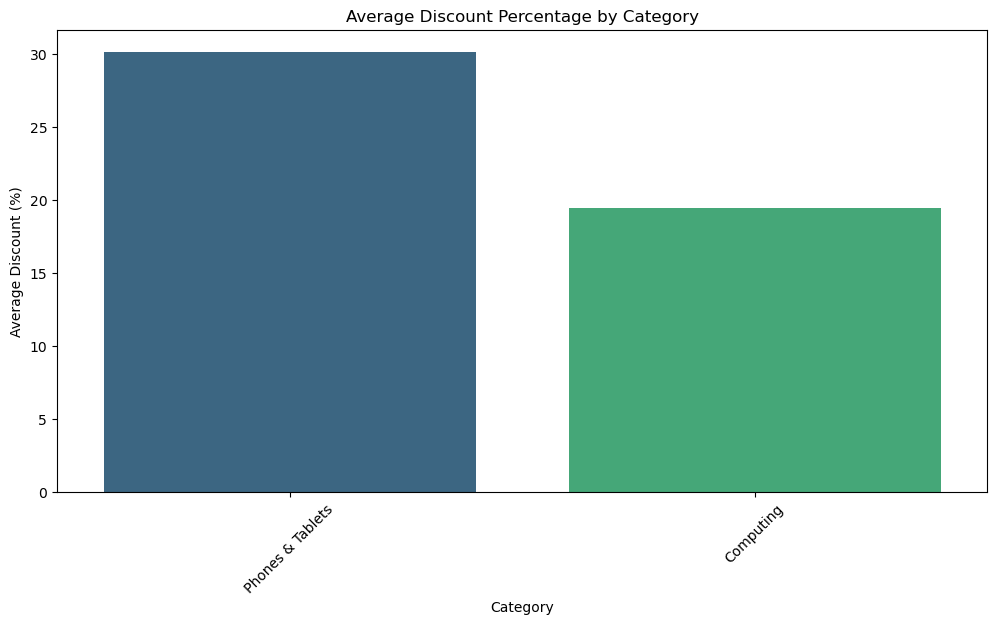

In [161]:
top_discount_categories = merged_df.groupby("Category")["Discount %"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_discount_categories.index, y=top_discount_categories.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Average Discount Percentage by Category")
plt.xlabel("Category")
plt.ylabel("Average Discount (%)")
plt.show()


In [171]:
# Filter rows where 'Title' contains "Laptop"
laptops = merged_df[
    merged_df["Title"].str.contains(r"Laptop.*RAM|RAM.*Laptop", case=False, na=False) &
    ~merged_df["Title"].str.contains(r"Skin|Cover|Sticker|Stand", case=False, na=False)
]

display(laptops.head(10))


Title     Price  Old Price  Rating     Badges   Category  Review Count  Discount %
94                                                                                                    Hp EliteBook 840 G6 Intel Core I5-8GB RAM/512GB SSD/Backlit Keyboard/FP Reader Wins 11 Laptop +BAG  485000.0        0.0     3.8  No badges  Computing           5.0    0.000000
97                                                                                              DELL Refurbished Dell Latitude E5470 14-Inch Laptop (Intel Core-i5-6300U Upto 3.0 GHz, 8GB RAM 256GB ROM  257626.0        0.0     3.3  No badges  Computing          19.0    0.000000
108                                                                                                                Hp STREAM 11 LAPTOP- CELERON-64GB 4D 4GB RAM Windows 10 PRO+ & USB Light For Keyboard  150000.0   250000.0     4.4  No badges  Computing          10.0   40.000000
114                                                                                                 Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO+ Mouse & USB Light For Keyboard  150000.0        0.0     4.0  No badges  Computing          21.0    0.000000
124                                                                                                 Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO+ Mouse & USB Light For Keyboard  145000.0   875000.0     3.8  No badges  Computing           5.0   83.428571
188                                                                                                         Hp ProBook 11 X360- Intel Pentium 256GB SSD-TOUCHSCREEN 8GB RAM Windows10 Pro + Laptop Pouch  290000.0        0.0     4.2  No badges  Computing          15.0    0.000000
194                                                                                                              Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 USB Light For Keyboard  140000.0        0.0     4.2  No badges  Computing           5.0    0.000000
213                                                                                               Hp ProBook 11 X360- Intel CELERON LAPTOPS - 128GB SSD-TOUCHSCREEN 4GB RAM Windows10 Pro + Laptop Pouch  210000.0        0.0     4.7  No badges  Computing          12.0    0.000000
270                                                                                                Hp Stream 11 Laptop- Intel Celeron - 128GB SSD 4GB RAM Windows 10 PRO+ Mouse & USB Light For Keyboard  180000.0        0.0     0.0  No badges  Computing           0.0    0.000000
359                                                                                                         Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO +USB Light For Keyboard  170000.0   340000.0     3.5  No badges  Computing           8.0   50.000000
410                                                                                                Hp Stream 11 LAPTOP Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO HP+ Mouse &USB Light For Keyboard  139500.0   200000.0     0.0  No badges  Computing           0.0   30.250000
504                                                                                               Hp EliteBook 840 G6 Intel Core I5-16GB RAM/512GB SSD/Backlit Keyboard/FP Reader Win11 Pro LAPTOPS +BAG  505000.0        0.0     5.0  No badges  Computing           1.0    0.000000
537                                                                               Hp Notebook 15.6" Touchscreen Laptop, Intel Core I3-12TH GEN 16GB RAM / 256GB SSD, Backlit Keyboard Windows 11 + MOUSE  595000.0        0.0     4.3  No badges  Computing          67.0    0.000000
622                                                                                                Hp EliteBook 840 G6 Intel Core I5-16GB RAM/1TB SSD/Backlit Keyboard/FP Reader Wins 11 Pro Laptop +BAG  560000.0        0.0     4.2  No badges  Computing          63.0    0.000000
633                      

In [168]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full text in cells

display(laptops) 

Title      Price  Old Price  Rating                  Badges          Category  Review Count  Discount %
0                                                                                                                                                                                                                EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand     4274.0     4787.0     4.1         Pay on Delivery         Computing        1654.0   10.716524
1                                                                                                                                                                                                    LZDUATAN 10 Steps Laptop Stand Desktop Stand Can Be Adjusted In     3199.0     5324.0     4.3         Pay on Delivery         Computing        2286.0   39.913599
3                                                                                                                                                                                                                                     LZDUATAN 10 Steps Laptop Stand     2954.0     5000.0     4.2               No badges         Computing        1943.0   40.920000
5                                                                                                                                                                                                                EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand     4399.0     5749.0     4.1         Pay on Delivery         Computing        1333.0   23.482345
11                                                                                                                                                                                                 GUEETON Metal Foldable Adjustable Stand Holder For Laptop  Silver     5178.0    10398.0     4.5         Pay on Delivery         Computing        1020.0   50.201962
16                                                                                                                                                                                                      MC Laptop Stand With Cooling Fan Low Noise Adjustable Height    14080.0    26750.0     4.5         Pay on Delivery         Computing         334.0   47.364486
18                                                                                                                                                                                               White Label Foldable Laptop Tablet Stand Adjustable Bracket - Black     2990.0     3300.0     3.0               No badges         Computing          24.0    9.393939
26                                                                                                                                                                                                       14" Laptop N3350 6GB+192GB SSD Portable Computer Student Pc   202860.0   289800.0     4.2         Pay on Delivery         Computing          19.0   30.000000
29                                                                                                                                                                                                          Foldable Portable Metal Laptop Stand With Detachable Fan     7990.0     9900.0     4.2         Pay on Delivery         Computing          37.0   19.292929
31                                                                                                                                                                                                                               Foldable Bedroom Laptop Study Table    11400.0    13000.0     4.6               No badges         Computing         409.0   12.307692
34                                                                                                                                                                                                                7 Steps Laptop Stand Desktop Stand Can Be Adjusted     3154.0     4351.0     3.3  Buy Any 2 Get 

In [177]:
print(laptops.shape)  


(46, 8)


In [182]:
display(cheapest_laptops)
print(cheapest_laptops.shape)  


Title     Price  Old Price  Rating     Badges   Category  Review Count  Discount %
410  Hp Stream 11 LAPTOP Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO HP+ Mouse &USB Light For Keyboard  139500.0   200000.0     0.0  No badges  Computing           0.0   30.250000
194                Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 USB Light For Keyboard  140000.0        0.0     4.2  No badges  Computing           5.0    0.000000
124   Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO+ Mouse & USB Light For Keyboard  145000.0   875000.0     3.8  No badges  Computing           5.0   83.428571
711   Hp Stream 11 Laptop- Intel Celeron - 64GB SSD 4GB RAM Windows 10 PRO+ Mouse & USB Light For Keyboard  145000.0        0.0     4.5  No badges  Computing           2.0    0.000000

(4, 8)


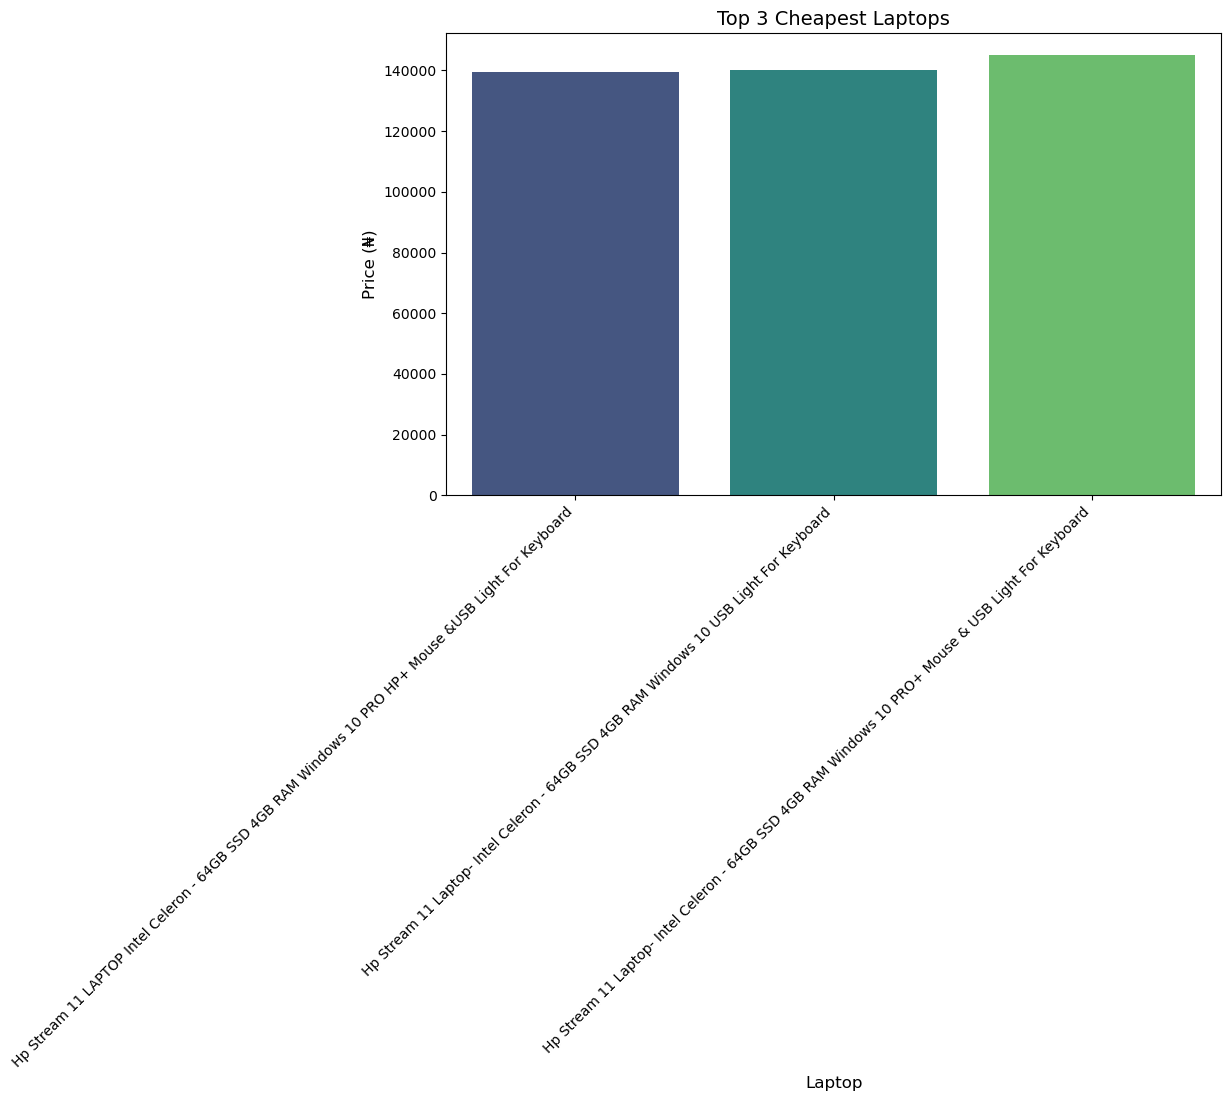

In [183]:
# Filter laptop items and select the 3 cheapest
cheapest_laptops = laptops.nsmallest(3, 'Price')

# Set figure size
plt.figure(figsize=(10, 6))

# Create barplot
sns.barplot(x=cheapest_laptops["Title"], y=cheapest_laptops["Price"], palette="viridis")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Add title and labels
plt.title("Top 3 Cheapest Laptops", fontsize=14)
plt.xlabel("Laptop", fontsize=12)
plt.ylabel("Price (₦)", fontsize=12)

# Show plot
plt.show()

In [186]:
display(laptops["Rating"].value_counts())


Rating
0.0    21
3.3     3
4.4     3
4.2     3
5.0     3
4.3     3
3.8     2
4.0     2
3.5     2
4.7     1
2.5     1
4.5     1
3.7     1
Name: count, dtype: int64

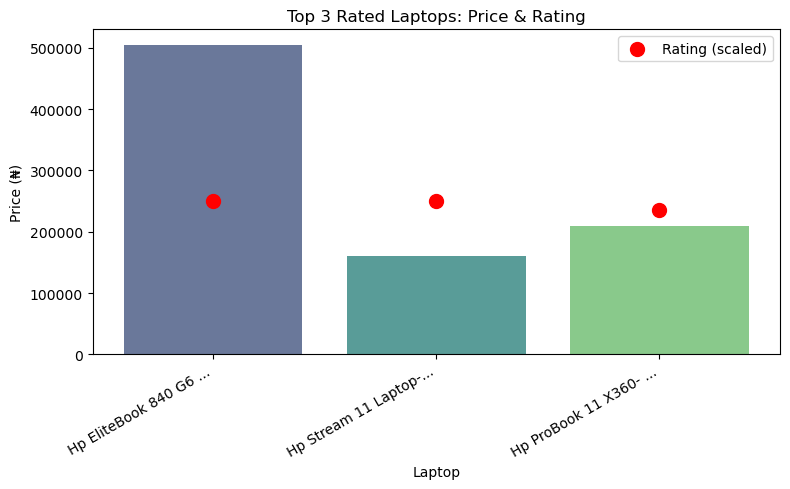

In [196]:
# Get top-rated unique laptops
most_rated_laptops = laptops.nlargest(10, 'Rating').drop_duplicates(subset="Title").head(3)

# Set figure size to prevent excessive width
fig, ax = plt.subplots(figsize=(8, 5))

# Shorten long laptop names for better display
most_rated_laptops["Short_Title"] = most_rated_laptops["Title"].apply(lambda x: x[:20] + "..." if len(x) > 20 else x)

# Barplot for Price
sns.barplot(x=most_rated_laptops["Short_Title"], y=most_rated_laptops["Price"], ax=ax, palette="viridis", alpha=0.8)

# Scatterplot for Ratings 
ax.scatter(most_rated_laptops["Short_Title"], most_rated_laptops["Rating"] * 50000, 
           color="red", label="Rating (scaled)", marker="o", s=100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30, ha="right")

# Add titles and labels
plt.title("Top 3 Rated Laptops: Price & Rating")
plt.xlabel("Laptop")
plt.ylabel("Price (₦)")

# Add legend
plt.legend()

# Adjust layout to fit labels
plt.tight_layout()

# Show plot
plt.show()

In [199]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full text in cells

display(merged_df) 

Title      Price   Old Price  Rating                  Badges          Category  Review Count  Discount %
0                                                                                                                                                                                                                         EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand     4274.0      4787.0     4.1         Pay on Delivery         Computing        1654.0   10.716524
1                                                                                                                                                                                                             LZDUATAN 10 Steps Laptop Stand Desktop Stand Can Be Adjusted In     3199.0      5324.0     4.3         Pay on Delivery         Computing        2286.0   39.913599
2                                                                                                                                                                                                              GUEETON LED 2.4G Rechargeable Wireless Mouse Bluetooth 2 Modes     4406.0      5537.0     4.4         Pay on Delivery         Computing        2517.0   20.426224
3                                                                                                                                                                                                                                              LZDUATAN 10 Steps Laptop Stand     2954.0      5000.0     4.2               No badges         Computing        1943.0   40.920000
4                                                                                                                                                                                                                             GUEETON 128GB OTG 3 In 1 Usb Flash Drive Type C     6695.0      9439.0     3.5         Pay on Delivery         Computing        2488.0   29.070876
5                                                                                                                                                                                                                         EAGEAT 10 Speed Adjustable Laptop Stand+phone Stand     4399.0      5749.0     4.1         Pay on Delivery         Computing        1333.0   23.482345
6                                                                                                                                                                                                                                    GUEETON Wireless Rechargeable Mouse 2.4G     4344.0      7552.0     4.3               No badges         Computing        4068.0   42.478814
7                                                                                                                                                                                                                 10 Inch LCD Writing Tablet Electronic Digital Drawing Board     3306.0      4980.0     4.4               No badges         Computing          45.0   33.614458
8                                                                                                                                                                                                            GUEETON 128GB Metal OTG Usb Flash Drive Waterproof 3D Embossment     6699.0      7483.0     3.5         Pay on Delivery         Computing        1664.0   10.477081
9                                                                                                                                                                                                               EAGEAT Pen Flash Drive 3.0 128GB - Metal OTG Micro USB Type-C     6474.0      8704.0     3.8         Pay on Delivery         Computing        1468.0   25.620404
10                                                                                                                                                                                                           

In [204]:
# Filter rows where 'Title' contains "Phone" and RAM
phones = merged_df[
    merged_df["Title"].str.contains(r"Phone.*RAM|RAM.*Phone", case=False, na=False)&
    ~merged_df["Title"].str.contains(r"Case|Protector|Cover|Sticker|Stand|MagSafe|Frame", case=False, na=False)   
]

# Display the filtered DataFrame
display(phones.head(10))

Title      Price  Old Price  Rating     Badges          Category  Review Count  Discount %
298               Kid 7" Children Android Educational Learning Kid Tablet Ìpad Phone Camera Core 4GB RAM 128G ROM Tab Quad Dual    94800.0        0.0     3.5  No badges         Computing          11.0    0.000000
1595                                    Kid 7" Children Android Educational Learning Kid Tablet Ìpad Phone 4GB RAM 128G ROM Tab   115000.0        0.0     5.0  No badges         Computing           1.0    0.000000
2350                                                           Apple IPhone 12 Pro Max - 6.7-Inch - 128GB ROM, 6GB RAM - IOS 14   880000.0        0.0     4.5  No badges  Phones & Tablets           2.0    0.000000
2379                                                                       Infinix Hot 50i Smart Phone With 128GB ROM & 4GB RAM   148399.0   200000.0     3.9  No badges  Phones & Tablets           9.0   25.800500
2386                                                                        Infinix Smart 8 Smart Phone With 64GB ROM & 2GB RAM   110499.0   155400.0     4.0  No badges  Phones & Tablets           2.0   28.893822
2418            Oppo A31 6GB RAM+128G ROM Refurbished Dual SIM6.5 Inch Screen HD Camera 12MP Face Unlock+Fingerprint Smartphone    98999.0   150999.0     4.2  No badges  Phones & Tablets         134.0   34.437314
2440                                                                             Apple IPhone 16 - 8GB-128GB - 5G - Ultramarine  1750000.0  1850000.0     0.0  No badges  Phones & Tablets           0.0    5.405405
2565                                                            Apple IPhone 13 6.1" , (4GB RAM + 128GB ROM), IOS 15 - Midnight   676354.0        0.0     3.7  No badges  Phones & Tablets           7.0    0.000000
2585                                                               Infinix Hot 50 Pro Plus Smart Phone With 128GB ROM & 8GB RAM   280399.0   391100.0     4.5  No badges  Phones & Tablets           2.0   28.305037
2603  Apple IPhone 11 6.1-Inch Liquid Retina LCD (4GB RAM, 64GB ROM) IOS 13, (12MP+12MP)+12MP 4G LTE Smartphone-Nano Sim-PURPLE   755000.0        0.0     0.0  No badges  Phones & Tablets           0.0    0.000000

In [206]:
print(expensive_vs_cheap.shape)


(10, 8)


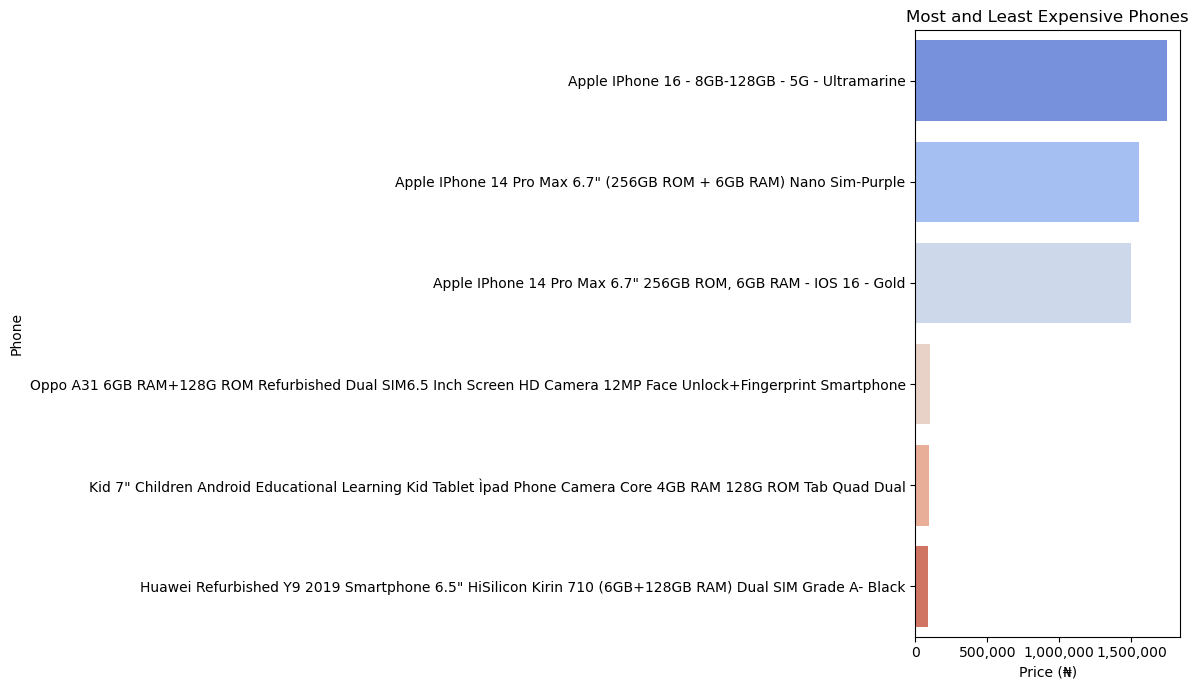

In [210]:
# Select the top 5 most expensive and least expensive phones
most_expensive = phones.nlargest(3, 'Price')
least_expensive = phones.nsmallest(3, 'Price')

# Combine both into one DataFrame
expensive_vs_cheap = pd.concat([most_expensive, least_expensive])

# Set figure size
plt.figure(figsize=(12, 7)) 

sns.barplot(
    y=expensive_vs_cheap["Title"], 
    x=expensive_vs_cheap["Price"], 
    palette="coolwarm", 
    order=expensive_vs_cheap.sort_values(by="Price", ascending=False)["Title"]
)

# Add title and labels
plt.title("Most and Least Expensive Phones")
plt.xlabel("Price (₦)")
plt.ylabel("Phone")

ax = plt.gca()  
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()  # Adjust layout to prevent label cutoffs

plt.show()


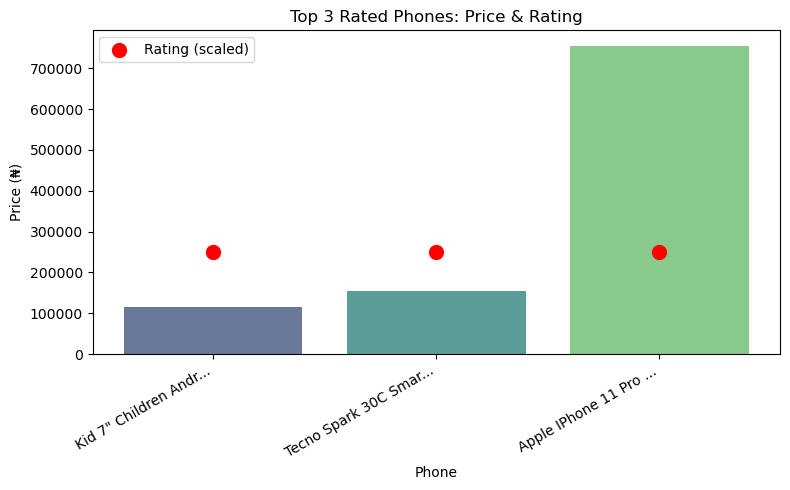

In [212]:
# Get top-rated unique phones
most_rated_phones = phones.nlargest(3, 'Rating').drop_duplicates(subset="Title").head(3)

# Set figure size to prevent excessive width
fig, ax = plt.subplots(figsize=(8, 5))

# Shorten long phone names for better display
most_rated_phones["Short_Title"] = most_rated_phones["Title"].apply(lambda x: x[:20] + "..." if len(x) > 20 else x)

# Barplot for Price
sns.barplot(x=most_rated_phones["Short_Title"], y=most_rated_phones["Price"], ax=ax, palette="viridis", alpha=0.8)

# Scatterplot for Ratings (Scaled for better visibility)
ax.scatter(most_rated_phones["Short_Title"], most_rated_phones["Rating"] * 50000, 
           color="red", label="Rating (scaled)", marker="o", s=100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30, ha="right")

# Add titles and labels
plt.title("Top 3 Rated Phones: Price & Rating", fontsize=12)
plt.xlabel("Phone", fontsize=10)
plt.ylabel("Price (₦)", fontsize=10)

# Add legend
plt.legend()

# Adjust layout to fit labels
plt.tight_layout()

# Show plot
plt.show()
